# Using the Dimensions API to Explore UCSD Research

This notebook explores Dimensions, an API that contains information about research publications, grants, datasets and more. We are specifically interested in research done at UCSD and affliated groups. In this notebook, I explore which publishers are used and collaborations between UCSD and other universities. 

# Contents:
1. [An Overview of Using Dimcli to Access Dimensions Data](#overview)
2. [Retrieving the Data](#data)
3. [Publishers](#publishers)
4. [Datasets](#datasets)
5. [Affiliations and Collaborations](#collabs)

To start off with, I primarily use Dimcli, a Python client for accessing the Dimensions API, which helps authenticate into the API and handle query requests/responses.

In [80]:
# necessary imports
import dimcli
import pandas as pd
import numpy as np
import json

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# visualization settings
sns.set_style("white")
sns.set(rc={'figure.figsize':(12, 10)})

In [3]:
# get access with config file. resource: https://digital-science.github.io/dimcli/getting-started.html# 
dimcli.login()

Searching config file credentials for default 'live' instance..


Dimcli - Dimensions API Client (v1.2)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.9
Method: dsl.ini file


In [5]:
dsl = dimcli.Dsl()

# An Overview of Using Dimcli to Access Dimensions Data <a class="anchor" id="overview"></a>

One way to query data from the API is using the dimcli instance to make queries. You can specify different conditions, such as how many objects to return, time period to search, and where to search for the keyword.

In [7]:
# note: you can also use the data attribute to get JSON of info!
dsl.query("search publications for \"malaria\" return publications limit 1")

Returned Publications: 1 (total = 1037619)
Time: 0.60s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


<dimcli.DslDataset object #1807324263664. Records: 1/1037619>

Another way to query information is to use Dimcli magic commands, created specifically for the Jupyter environment, that run faster. This specific command returns a pandas dataframe.

In [6]:
%%dsldf

search publications 
    for "malaria"
return publications [title + research_orgs + research_org_names + times_cited + funders]
limit 5

Returned Publications: 5 (total = 1038969)
Time: 2.15s


,title,funders,research_org_names,research_orgs,times_cited
0,Case-based malaria surveillance and response: ...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...","[Yangzhou University, Nanjing Medical Universi...","[{'acronym': 'NMU', 'city_name': 'Nanjing', 'c...",2
1,Spatio-temporal patterns of malaria in Nepal f...,NaN,[University of Florida],"[{'acronym': 'UF', 'city_name': 'Gainesville',...",1
2,Laboratory diagnosis for malaria in the elimin...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...",[National Institute for Parasitic Diseases],"[{'acronym': 'NIPD', 'city_name': 'Shanghai', ...",12
3,Cross-sectional prevalence and pattern of non-...,NaN,"[MRC Unit the Gambia, Usmanu Danfodiyo Univers...","[{'acronym': 'UDUTH', 'city_name': 'Sokoto', '...",0
4,Trends in malaria indicators after scale-up of...,"[{'acronym': 'NIMH', 'city_name': 'Bethesda', ...","[United Nations Development Programme, Kabul, ...","[{'acronym': 'UCSF', 'city_name': 'San Francis...",2


In [8]:
# all magic commands result stored in..
dsl_last_results.head()

,title,funders,research_org_names,research_orgs,times_cited
0,Case-based malaria surveillance and response: ...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...","[Yangzhou University, Nanjing Medical Universi...","[{'acronym': 'NMU', 'city_name': 'Nanjing', 'c...",2
1,Spatio-temporal patterns of malaria in Nepal f...,NaN,[University of Florida],"[{'acronym': 'UF', 'city_name': 'Gainesville',...",1
2,Laboratory diagnosis for malaria in the elimin...,"[{'acronym': 'BMGF ', 'city_name': 'Seattle', ...",[National Institute for Parasitic Diseases],"[{'acronym': 'NIPD', 'city_name': 'Shanghai', ...",12
3,Cross-sectional prevalence and pattern of non-...,NaN,"[MRC Unit the Gambia, Usmanu Danfodiyo Univers...","[{'acronym': 'UDUTH', 'city_name': 'Sokoto', '...",0
4,Trends in malaria indicators after scale-up of...,"[{'acronym': 'NIMH', 'city_name': 'Bethesda', ...","[United Nations Development Programme, Kabul, ...","[{'acronym': 'UCSF', 'city_name': 'San Francis...",2


# Retrieving the Data <a class="anchor" id="data"></a>

Let's start querying and build a pandas dataframe to do some exploratory data analysis on research done at UCSD. 

In [105]:
GRIDID_LIST = ["grid.266100.3", "grid.420234.3", "grid.413086.8"]
GRID_NAMES = ['University of California, San Diego', 'UC San Diego Health System', 
              'University of California San Diego Medical Center'] # corresponds to the grid IDs
# other possible orgs - Rady's Children hospital, Supercomputer Center

FIELDS = "title+type+year+journal+authors+research_orgs+research_org_names+publisher+times_cited+funders+authors_count+category_for"

In [106]:
# search publications from 2024, limit to 300 because of API limits
query = f"""search publications
            where research_orgs.id in {json.dumps(GRIDID_LIST)} and year=2024
            return publications[{FIELDS}] sort by year"""
result = dsl.query(query)

Returned Publications: 20 (total = 3597)
Time: 0.77s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


The above query only returns 20 publications out of 3597. However, to get a more accurate understanding of all publications from 2024 at UCSD, we could instead iteratively query over the Dimension records and get 300 records at a time, which avoids Dimension restrictions on number of queries that you can make.

In [107]:
result = dsl.query_iterative(query, limit=300)

Starting iteration with limit=300 skip=0 ...
0-300 / 3597 (2.52s)
300-600 / 3597 (2.37s)
600-900 / 3597 (3.36s)
900-1200 / 3597 (2.90s)
1200-1500 / 3597 (1.93s)
1500-1800 / 3597 (2.65s)
1800-2100 / 3597 (2.43s)
2100-2400 / 3597 (3.35s)
2400-2700 / 3597 (3.41s)
2700-3000 / 3597 (6.41s)
3000-3300 / 3597 (5.37s)
3300-3597 / 3597 (3.11s)
===
Records extracted: 3597
Warnings:  12


In [108]:
# turn result from Dimcli query into pandas dataframe
pubs = result.as_dataframe()
pubs.head()

,title,authors,authors_count,category_for,funders,publisher,research_org_names,research_orgs,times_cited,type,year,journal.id,journal.title
0,Elevated Biomarkers of Inflammation and Vascul...,"[{'affiliations': [{'city': 'San Diego', 'city...",7,"[{'id': '80034', 'name': '3101 Biochemistry an...","[{'acronym': 'NIMH', 'city_name': 'Bethesda', ...",MDPI,"[University of California, San Diego, Universi...","[{'acronym': 'UNC', 'city_name': 'Chapel Hill'...",0,article,2024,jour.1028874,International Journal of Molecular Sciences
1,Which sagittal plane assessment method is most...,"[{'affiliations': [{'city': 'Madrid', 'city_id...",10,"[{'id': '80136', 'name': '4201 Allied Health a...","[{'acronym': 'ORD', 'city_name': 'Washington D...",NaN,"[Vall d'Hebron Hospital Universitari, Schulthe...","[{'acronym': 'UTSA', 'city_name': 'San Antonio...",0,article,2024,jour.1048106,Spine Deformity
2,The Role of High-Resolution Manometry Prior to...,"[{'affiliations': [{'city': 'Padova', 'city_id...",16,"[{'id': '80003', 'name': '32 Biomedical and Cl...",NaN,NaN,"[University of Padua, Medicine & Surgery, Univ...","[{'acronym': 'HCL', 'city_name': 'Lyon', 'coun...",0,article,2024,jour.1017225,Annals of Surgery
3,Pathogenesis of sleep disordered breathing in ...,"[{'affiliations': [{'city': 'San Diego', 'city...",8,"[{'id': '80057', 'name': '3214 Pharmacology an...",NaN,Oxford University Press (OUP),"[University of California, San Diego, Harvard ...","[{'acronym': 'BWH', 'city_name': 'Boston', 'co...",0,article,2024,jour.1088755,Sleep
4,Extracting accurate light–matter couplings fro...,"[{'affiliations': [{'city': 'San Diego', 'city...",3,"[{'id': '80227', 'name': '5108 Quantum Physics...","[{'acronym': 'AFOSR', 'city_name': 'Arlington'...",NaN,"[University of California, San Diego, Universi...","[{'acronym': 'UM', 'city_name': 'Ann Arbor', '...",0,article,2024,jour.1048376,Nanophotonics


In [14]:
pubs.shape

(3597, 12)

Next, I clean the data and reformat it to make it easier to work with. Specifically, I extract the funder name into a separate column and also extract the category names from dictionaries into lists with just the category name, as categorized by the Australian and New Zealand Standard Research Classification (ANZSRC).

In [123]:
# the funders information is given a list of dictionaries, each dictionary represents the info for a funder
# check if it's a float because some of the column values are NaN
pubs['funder_name'] = pubs['funders'].apply(lambda x : [] if isinstance(x, float)
                                            else [dict['name'] for dict in x])

In [124]:
# category_for format is a list of dictionaries, each dictionary containing the keys id and name
# only include broad categories from the ANZSRC, which have 2-digit codes 
pubs['overall_cat'] = pubs['category_for'].apply(lambda x : [] if isinstance(x, float)
                                                 else [dict['name'] for dict in x if not dict['name'][0:4].isdigit()])

# Publishers <a class="anchor" id="publishers"></a>

Let's explore which publishers are UCSD researchers publishing in, so we can compare to the current contracts the library has to publishers. Below, I create a simple dataframe and delete the publishers with less than ten publications to simplify our visualization.

In [101]:
# create dataframe to combine the publishers with only 1 publication into the group Other
count_publisher = pubs['publisher'].value_counts().reset_index()
other_num = count_publisher[count_publisher['publisher'] < 10]['publisher'].sum()
count_publisher = count_publisher[count_publisher['publisher'] >= 10] # delete publishers with <4 publications
# count_publisher.loc[len(count_publisher)] = ['Other', other_num] # add row for the Other
count_publisher.head()

,index,publisher
0,Elsevier,863
1,Springer Nature,466
2,Wiley,238
3,Cold Spring Harbor Laboratory,205
4,Wolters Kluwer,184


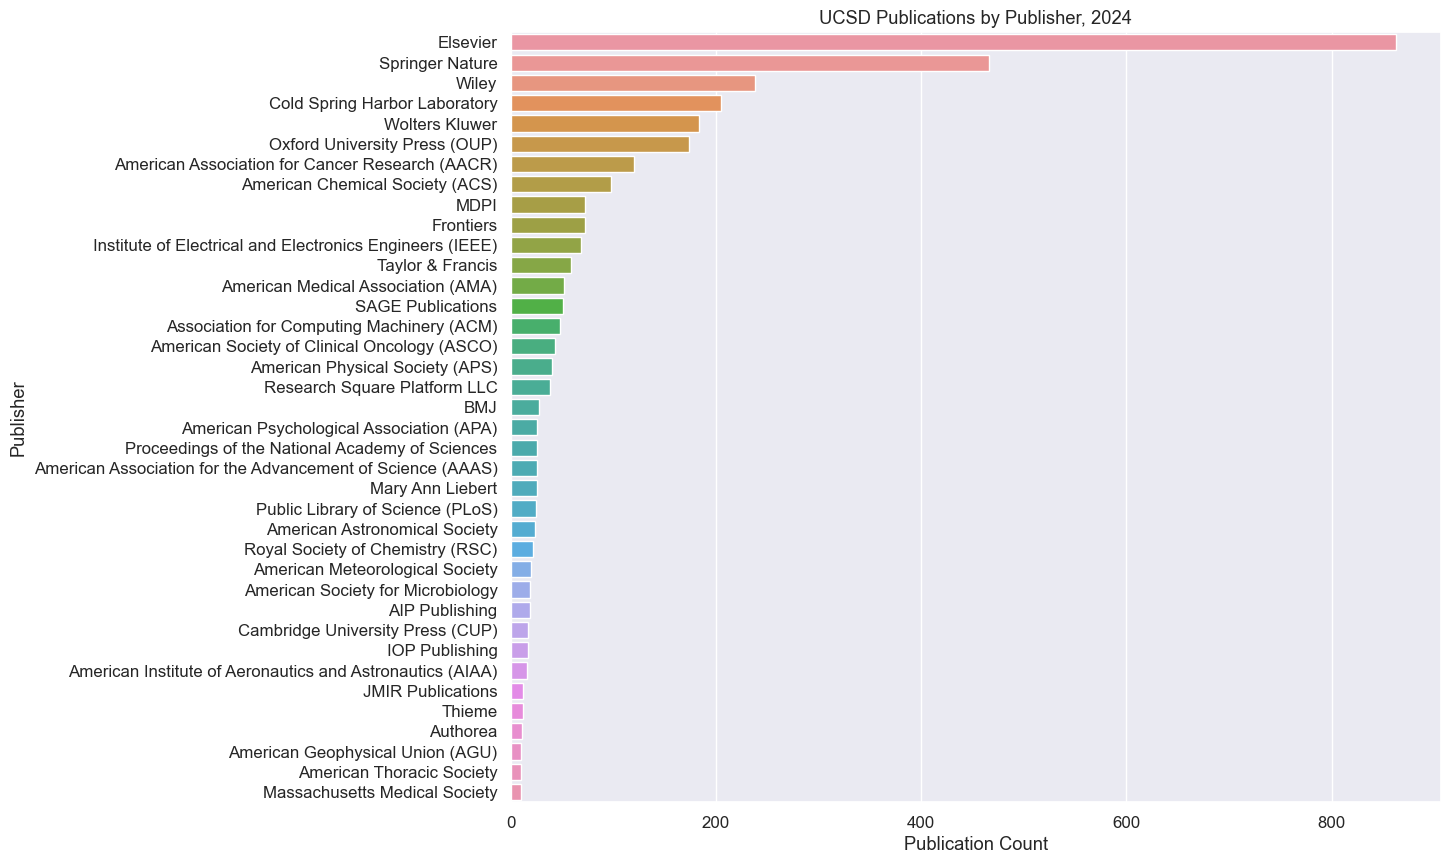

In [102]:
sns.set(font_scale=1.1)
sns.barplot(count_publisher, x="publisher", y="index", order=count_publisher['index'])
plt.xlabel('Publication Count')
plt.ylabel('Publisher')
plt.title('UCSD Publications by Publisher, 2024')
plt.show()

Originally, I had a pie chart to visualize this information, but later switched to a bar graph, which displays a large number of publishers more clearly and allows viewers to more accurately gage how many publications there are in each category. 

I notice that the top publishers in 2024 are Elsevier, Springer Nature, and Wiley. Does this breakdown change based on domain? For example, do researchers in Biology publish in different places than researchers in the Computer Science department? 

In [138]:
pubs['overall_cat'].value_counts()

[32 Biomedical and Clinical Sciences]                                                   1344
[31 Biological Sciences]                                                                 305
[40 Engineering]                                                                         171
[42 Health Sciences]                                                                     159
[51 Physical Sciences]                                                                   148
                                                                                        ... 
[38 Economics, 42 Health Sciences, 44 Human Society]                                       1
[35 Commerce, Management, Tourism and Services, 50 Philosophy and Religious Studies]       1
[52 Psychology, 39 Education]                                                              1
[37 Earth Sciences, 51 Physical Sciences]                                                  1
[44 Human Society, 32 Biomedical and Clinical Sciences]               

In [ ]:
cats = ['52 Psychology', 'Engineering', 'Biological Sciences']
df = 

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 6))

What topics do the publications write about? Let's get an overview with a word-cloud visualization.

In [14]:
# https://api-lab.dimensions.ai/cookbooks/2-publications/Simple-topic-analysis.html

# Datasets <a class="anchor" id="datasets"></a>

At UCSD, where are people publishing datasets? 

In [15]:
#%dsldf search datasets for "machine learning" return datasets

# Affliations and Collaborations<a class="anchor" id="collabs"></a>

Let's find out which universities UCSD, and other affliated organizations like UCSD Health and UCSD Medical Center, are collaborating with on publications. We analyze these collaborations by looking at which research organizations are listed for each publication. 

In [103]:
# build df with geographical information and collaborations info
# includes collaborations with the 3 different UCSD related grid IDs
# loop through all research_orgs 
collabs = pd.DataFrame(columns=['lat', 'long', 'collabNum', 'type'])
for orgs_list in pubs['research_orgs']:
    for org in orgs_list:
        if 'latitude' not in org or 'longitude' not in org: # if org doesn't have lat/long info, skip it
            print(org)
            continue
        if org['name'] in GRID_NAMES: # if org is UCSD related, skip
            continue
        if org['name'] not in collabs.index:
            collabs.loc[org['name']] = [org['latitude'], org['longitude'], 1, org['types'][0]]
        else: # uni already in the dataframe
            collabs.at[org['name'], 'collabNum'] += 1
            #collabs.loc[org['name']]['collabNum'] += 1


{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'na

Now, we use the dataframe we built to plot this information on a map, with larger circles indicating more collaborations. 

In [104]:
# now make plotly graph with this df
fig = px.scatter_geo(collabs, lat='lat', lon='long', hover_name=collabs.index, size='collabNum', 
                     color='collabNum', color_continuous_scale="sunset_r")
fig.show()

We notice that the universities with the highest number of collaborations are mainly centered in the US and include Harvard, John Hopkins, UCSF, and Stanford.

In this section, we want to build a network of affliations and collaborations between researchers. We want to look if there are common collaborations cross-university, with implications of building more formal collabortions based on who tends to work together.

We first look at what the research orgs for each publication might look like by looking at the research_org_names column.

In [11]:
pubs.loc[1]['research_org_names']

['National Taiwan University',
 'Leung Center for Cosmology and Astroparticle Physics, 10617, Taipei, Taiwan',
 'University of California, San Diego',
 'University of Amsterdam']

We notice that some lists of research orgs are quite long. We look at why this is by creating a visualization for number of research_org_names versus number of authors. 

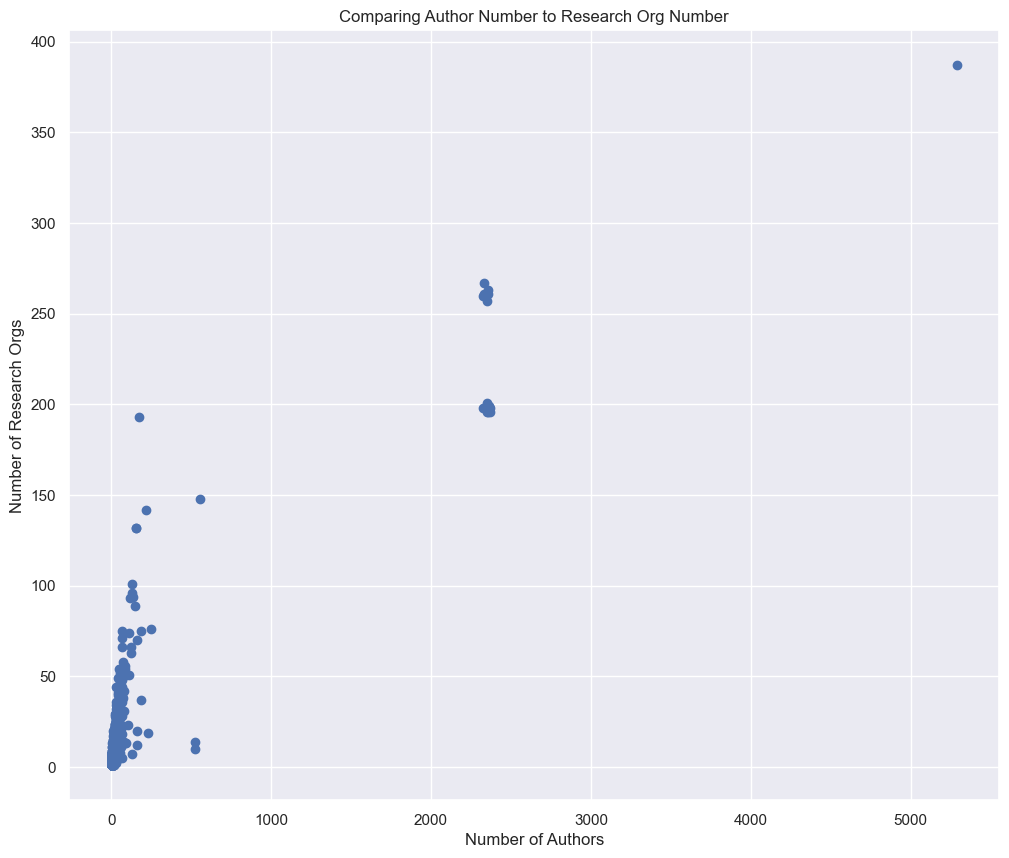

In [30]:
plt.scatter(pubs['authors_count'], pubs['research_org_names'].apply(lambda ls : len(ls)))
plt.xlabel('Number of Authors')
plt.ylabel('Number of Research Orgs')
plt.title('Comparing Author Number to Research Org Number')
plt.show()

We notice that there is a very general trend of number of research orgs increasing when number of authors increase. We can guess that this is because the authors might be affliated with different research organizations. Furthermore, we notice that astonishingly, some publications have more than 1000 authors.

In [13]:
len(pubs[pubs['authors_count'] > 1000])

18

With this information in mind, let's limit which edges we put into our graph. We create a graph where each node represents a unversity, and each edge represents number of publications that they have collaborated on. Two universities have collaborated on a publication if they are both listed on the research_org_names column from our dataset. However, we will exclude edges with less than 5 publications to narrow our search. Moreover, all nodes will be connected with either UCSD, UCSD Medical Center, or UCSD Health System, as the three groups that we are primarily interested in. 

Let's use pyvis, a Python package for interactive network visualizations, to build the graph and visualize it. First, let's go through the list of research orgs for each publication and write the information into a dictionary. Let's just go through those with UCSD as a research org to simplify the process, and consider the other two (UCSD Medical Center and UCSD Health System) later.

In [88]:
# this dictionary will contain info for all universities that are collaborators with UCSD on publications, including 
# number of collaborations they have. key : value where key is uni name, value is number of publications collaborated on
ucsd_dict = {}

for ls in pubs['research_org_names']:
    for uni in ls: 
        if uni == 'University of California, San Diego':
            continue
        if uni in ucsd_dict: 
            ucsd_dict[uni] += 1 # increment publication number
        else: 
            ucsd_dict[uni] = 1

In [89]:
# now remove universities with <5 collaborated publications
ucsd_dict_new = {key: val for key, val in ucsd_dict.items() if val >= 10}

Now, let's create a pyvis graph using our dictionary information. 

In [79]:
# initialize graph
g = net.Network(notebook=True)
g.repulsion()

# add nodes
g.add_node('University of California, San Diego') # everything will be connected to this node
g.add_nodes(list(ucsd_dict_new.keys()))

# add edges
edge_ls = [('University of California, San Diego',) + tup for tup in list(ucsd_dict_new.items())]
g.add_edges(edge_ls)

g.show('collabs.html')

collabs.html


graph viz with NETWORKX

In [85]:
# each node is a university. each edge represents number of publications that they have collaborated on 
G = nx.Graph()

In [90]:
# add nodes. takes in a list of universities
def addNodeEdges(ls):
    G.add_node('University of California, San Diego')
    G.add_nodes_from(list(ucsd_dict_new.keys()))
    
    # add edges
    edge_ls = [('University of California, San Diego',) + tup for tup in list(ucsd_dict_new.items())]
    G.add_weighted_edges_from(edge_ls)
    
#     for uni in ls: 
#         # if uni is UCSD, continue
#         # if uni not in graph, add and add edge between UCSD and uni
#         # else, increase edge weight of UCSD, uni 
#         if uni == 'University of California, San Diego':
#             continue

#         if uni in G.nodes:
#             curr_weight = G.edges[uni, 'University of California, San Diego']['weight']
#             G.edges[uni, 'University of California, San Diego']['weight'] = curr_weight + 1
#         else:
#             G.add_node(uni)
#             G.add_edge(uni, 'University of California, San Diego', weight=1)

In [91]:
pubs['research_org_names'].apply(addNodeEdges)

0       None
1       None
2       None
3       None
4       None
        ... 
3325    None
3326    None
3327    None
3328    None
3329    None
Name: research_org_names, Length: 3330, dtype: object

C:\Users\lulennemann\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


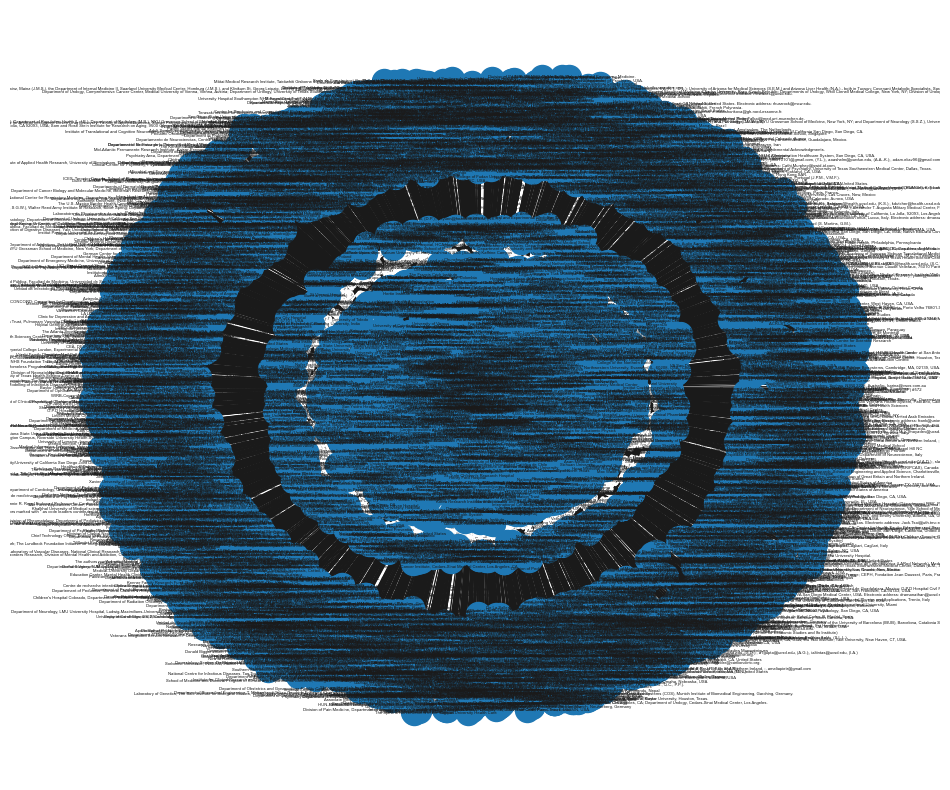

In [92]:
# plot the network of collaborations 
nx.draw_networkx(G, font_size=3)

# add edge labels
pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=3)

plt.axis("off")
plt.show()

In [29]:
from pyvis.network import Network
net = Network()
net.from_nx(G)
net.show('nx.html', notebook=False)
net.show_buttons(filter_=['physics'])

nx.html
